# This Notebook Perform two things...........

# 1 Section:                                                                 
Research Area Subject Area Prediction (Large Scale classification) using shallow Multi-Layer Perceptron (MLP) model

# 2 Section:
Research Paper Recommendation for reading: using sentence transformer model

Research Papers dataset link::
https://www.kaggle.com/datasets/spsayakpaul/arxiv-paper-abstracts/data


# 1 Section:                                                                 

# Loading tools and dataset

In [1]:
from tensorflow.keras import layers
from tensorflow import keras
import tensorflow as tf

from sklearn.model_selection import train_test_split

from ast import literal_eval
# is used for safely evaluating strings containing Python literals or container displays
# (e.g., lists, dictionaries) to their corresponding Python objects.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

/Users/ashhadahmed/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
arxiv_data = pd.read_csv("data.csv")

In [3]:
arxiv_data.head()

,terms,titles,abstracts
0,['cs.LG'],Multi-Level Attention Pooling for Graph Neural...,Graph neural networks (GNNs) have been widely ...
1,"['cs.LG', 'cs.AI']",Decision Forests vs. Deep Networks: Conceptual...,Deep networks and decision forests (such as ra...
2,"['cs.LG', 'cs.CR', 'stat.ML']",Power up! Robust Graph Convolutional Network v...,Graph convolutional networks (GCNs) are powerf...
3,"['cs.LG', 'cs.CR']",Releasing Graph Neural Networks with Different...,With the increasing popularity of Graph Neural...
4,['cs.LG'],Recurrence-Aware Long-Term Cognitive Network f...,Machine learning solutions for pattern classif...


# Data Cleaning and Preprocessing

In [4]:
arxiv_data.shape

(56181, 3)

In [5]:
arxiv_data.isnull().sum()

terms        0
titles       0
abstracts    0
dtype: int64

In [6]:
arxiv_data.duplicated().sum()

15054

In [7]:
# getting unique labels
labels_column = arxiv_data['terms'].apply(literal_eval)
labels = labels_column.explode().unique()
print("labels :",labels)
print("lenght :",len(labels))

labels : ['cs.LG' 'cs.AI' 'cs.CR' ... 'D.1.3; G.4; I.2.8; I.2.11; I.5.3; J.3'
 '68T07, 68T45, 68T10, 68T50, 68U35' 'I.2.0; G.3']
lenght : 1177


In [8]:
# remove duplicate entries based on the "titles" (terms) column
# This filters the DataFrame, keeping only the rows where the titles are not duplicated.
arxiv_data = arxiv_data[~arxiv_data['titles'].duplicated()]
print(f"There are {len(arxiv_data)} rows in the deduplicated dataset.")
# There are some terms with occurrence as low as 1.
print(sum(arxiv_data['terms'].value_counts()==1))
# how many unique terms
print(arxiv_data['terms'].nunique())

There are 41105 rows in the deduplicated dataset.
2503
3401


In [9]:
# Filtering the rare terms. (it keeps only those rows where the "terms" value occurs more than once in the original DataFrame.)
arxiv_data_filtered = arxiv_data.groupby('terms').filter(lambda x: len(x) > 1)
arxiv_data_filtered.shape

(38602, 3)

In [10]:
# It evaluates the given string containing a Python literal or container display (e.g., a list or dictionary) and returns the corresponding Python object.
arxiv_data_filtered['terms'] = arxiv_data_filtered['terms'].apply(lambda x: literal_eval(x))
arxiv_data_filtered['terms'].values[:3]

array([list(['cs.LG']), list(['cs.LG', 'cs.AI']),
       list(['cs.LG', 'cs.CR', 'stat.ML'])], dtype=object)

# train and test split.

In [11]:
test_split = 0.1

# Initial train and test split.
# The stratify parameter ensures that the splitting is done in a way that preserves the same distribution of labels (terms) in both the training and test sets.
train_df, test_df = train_test_split(arxiv_data_filtered,test_size=test_split,stratify=arxiv_data_filtered["terms"].values,)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 34741
Number of rows in validation set: 1930
Number of rows in test set: 1931


In [12]:
# creates a TensorFlow RaggedTensor (terms) from the values in the "terms" column of the train_df DataFrame. A RaggedTensor is a tensor with non-uniform shapes
terms = tf.ragged.constant(train_df['terms'].values)
# This line creates a StringLookup layer in TensorFlow. The purpose of this layer is to map strings to integer indices and vice versa. The output_mode="multi_hot" indicates that the layer will output a multi-hot encoded representation of the input strings.
lookup = tf.keras.layers.StringLookup(output_mode='multi_hot')
# This step adapts the StringLookup layer to the unique values in the "terms" column, building the vocabulary.
lookup.adapt(terms)
# retrieve vocabulary
vocab = lookup.get_vocabulary()

print("Vocabulary:\n")
print(vocab)

Vocabulary:

['[UNK]', 'cs.CV', 'cs.LG', 'stat.ML', 'cs.AI', 'eess.IV', 'cs.RO', 'cs.CL', 'cs.NE', 'cs.GR', 'cs.CR', 'math.OC', 'eess.SP', 'cs.SI', 'cs.MM', 'cs.SY', 'cs.IR', 'eess.SY', 'cs.MA', 'cs.HC', 'math.IT', 'cs.IT', 'cs.DC', 'stat.AP', 'cs.CY', 'stat.ME', 'stat.TH', 'math.ST', 'eess.AS', 'cs.SD', 'cs.DS', 'q-bio.QM', 'q-bio.NC', 'cs.CG', 'stat.CO', 'cs.NI', 'cs.GT', 'math.NA', 'cs.SE', 'I.2.6', 'cs.NA', 'physics.chem-ph', 'cs.DB', 'physics.comp-ph', 'cond-mat.dis-nn', 'q-bio.BM', 'math.PR', 'cs.LO', 'cs.PL', '68T45', 'cs.AR', 'physics.data-an', 'quant-ph', 'I.2.10', 'cs.CE', 'cond-mat.stat-mech', 'q-fin.ST', 'I.4.6', 'physics.ao-ph', 'math.DS', 'cs.CC', '68T05', 'physics.soc-ph', 'physics.med-ph', 'cs.PF', 'q-bio.GN', 'econ.EM', 'cs.DM', 'I.4.8', 'astro-ph.IM', 'physics.flu-dyn', 'math.AT', 'hep-ex', 'I.4', '68U10', 'q-fin.TR', 'physics.geo-ph', 'cs.FL', 'I.5.4', 'I.2', 'cond-mat.mtrl-sci', 'I.4.9', '68T10', 'physics.optics', 'I.4; I.5', '68T07', 'q-fin.CP', 'math.CO', 'math.AP

In [13]:
sample_label = train_df["terms"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['stat.ML', 'cs.LG']
Label-binarized representation: [[0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [14]:
# following lines::
# which is used for automatic adjustment of resource usage by TensorFlow's data loading pipeline.

#max_seqlen: Maximum sequence length. It indicates the maximum length allowed for sequences.
max_seqlen = 150
#batch_size: Batch size. It specifies the number of samples to use in each iteration.
batch_size = 128
#padding_token: A token used for padding sequences.
padding_token = "<pad>"
#auto = tf.data.AUTOTUNE: auto is assigned the value tf.data.AUTOTUNE,
auto = tf.data.AUTOTUNE

def make_dataset(dataframe, is_train=True):
    # creating sequences of labesls
    labels = tf.ragged.constant(dataframe["terms"].values)
    #This line uses the previously defined lookup layer to convert the ragged tensor of labels into a binarized representation. The resulting label_binarized is a NumPy array.
    label_binarized = lookup(labels).numpy()
    # creating sequences of text.
    dataset = tf.data.Dataset.from_tensor_slices((dataframe["abstracts"].values, label_binarized))
    # shuffling data basis on condition
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

"""
In summary, the make_dataset function is designed to create a 
dataset suitable for training a model. It takes a dataframe as input, 
assumes it has "abstracts" and "terms" columns, and creates a dataset of 
batches where each batch consists of abstract 
sequences and their corresponding binarized label sequences. 
"""

'\nIn summary, the make_dataset function is designed to create a \ndataset suitable for training a model. It takes a dataframe as input, \nassumes it has "abstracts" and "terms" columns, and creates a dataset of \nbatches where each batch consists of abstract \nsequences and their corresponding binarized label sequences. \n'

In [15]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [16]:
import pickle
# Load the vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)


In [17]:
def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)

In [18]:
# This code snippet is iterating through batches of the training dataset and printing the abstract text along with the corresponding labels.
text_batch, label_batch = next(iter(train_dataset))
for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")

Abstract: b'Learning graphical structures based on Directed Acyclic Graphs (DAGs) is a\nchallenging problem, partly owing to the large search space of possible graphs.\nA recent line of work formulates the structure learning problem as a continuous\nconstrained optimization task using the least squares objective and an\nalgebraic characterization of DAGs. However, the formulation requires a hard\nDAG constraint and may lead to optimization difficulties. In this paper, we\nstudy the asymptotic role of the sparsity and DAG constraints for learning DAG\nmodels in the linear Gaussian and non-Gaussian cases, and investigate their\nusefulness in the finite sample regime. Based on the theoretical results, we\nformulate a likelihood-based score function, and show that one only has to\napply soft sparsity and DAG constraints to learn a DAG equivalent to the ground\ntruth DAG. This leads to an unconstrained optimization problem that is much\neasier to solve. Using gradient-based optimization and

In [19]:
# This code calculates the size of the vocabulary in the "abstracts" column of the train_df DataFrame.

# Creating vocabulary with uniques words
vocabulary = set()
train_df["abstracts"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

159017


# Text Vectorization

In [20]:
from tensorflow.keras.layers import TextVectorization

# Recreate layer with max_tokens
text_vectorizer = TextVectorization(
    max_tokens=159077,  # use the original max_tokens
    output_mode="tf_idf"
)

# Re-adapt on training dataset
text_vectorizer.adapt(train_dataset.map(lambda text, label: text))


In [21]:
"""
Mapping Vectorization to Datasets: The code maps the text vectorization operation to 
each element of the training, validation, and test datasets. This ensures that the text
data in each dataset is transformed into numerical vectors using the adapted TextVectorization layer.
The num_parallel_calls parameter is used to parallelize the mapping process, and prefetch is 
applied to prefetch data batches 
for better performance.
"""
train_dataset = train_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
validation_dataset = validation_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)
test_dataset = test_dataset.map(lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto).prefetch(auto)

# model training

In [22]:
# creating shallow_mlp_model  (MLP)
from tensorflow.keras.callbacks import EarlyStopping

# Creating shallow_mlp_model (MLP) with dropout layers
model1 = keras.Sequential([
    # First hidden layer: 512 neurons, ReLU activation function, with dropout.
    layers.Dense(512, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Second hidden layer: 256 neurons, ReLU activation function, with dropout.
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),  # Adding dropout for regularization.

    # Output layer: The number of neurons equals the vocabulary size (output vocabulary of the StringLookup layer), with a sigmoid activation function.
    layers.Dense(lookup.vocabulary_size(), activation='sigmoid')
])

# Compile the model
model1.compile(loss="binary_crossentropy", optimizer='adam', metrics=['binary_accuracy'])

# Add early stopping
# Number of epochs with no improvement after which training will be stopped.
# Restore weights from the epoch with the best value of the monitored quantity.
early_stopping = EarlyStopping(patience=5,restore_best_weights=True)

# Train the model
# Add early stopping callback.verbose=1
history = model1.fit(train_dataset,validation_data=validation_dataset,epochs=5,callbacks=[early_stopping])

Epoch 1/5
272/272 [==============================] - 32s 116ms/step - loss: 0.0451 - binary_accuracy: 0.9843 - val_loss: 0.0183 - val_binary_accuracy: 0.9945
Epoch 2/5
272/272 [==============================] - 32s 119ms/step - loss: 0.0167 - binary_accuracy: 0.9950 - val_loss: 0.0175 - val_binary_accuracy: 0.9946
Epoch 3/5
272/272 [==============================] - 33s 120ms/step - loss: 0.0123 - binary_accuracy: 0.9960 - val_loss: 0.0184 - val_binary_accuracy: 0.9943
Epoch 4/5
272/272 [==============================] - 33s 122ms/step - loss: 0.0094 - binary_accuracy: 0.9969 - val_loss: 0.0201 - val_binary_accuracy: 0.9941
Epoch 5/5
272/272 [==============================] - 33s 122ms/step - loss: 0.0075 - binary_accuracy: 0.9976 - val_loss: 0.0216 - val_binary_accuracy: 0.9942


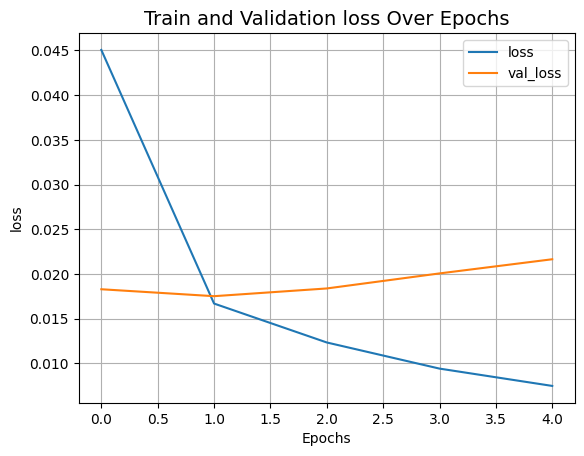

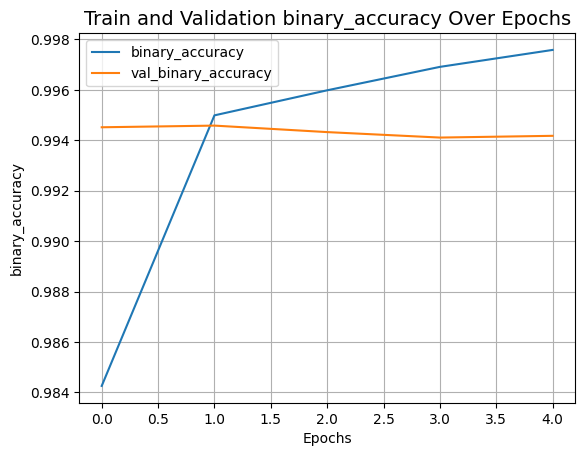

In [23]:
# plotting loss
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("binary_accuracy")

# Model Evaluation

In [24]:
# model evaltuation on test and val dataset
_, binary_acc1 = model1.evaluate(test_dataset)
_, binary_acc2 = model1.evaluate(validation_dataset)

print(f"Categorical accuracy on the test set: {round(binary_acc1 * 100, 2)}%.")
print(f"Categorical accuracy on the validation set: {round(binary_acc2 * 100, 2)}%.")

16/16 [==============================] - 1s 51ms/step - loss: 0.0216 - binary_accuracy: 0.9942
Categorical accuracy on the test set: 99.43%.
Categorical accuracy on the validation set: 99.42%.


# Save Model and Text Vectorizer:

In [25]:
import pickle
import numpy as np
from tensorflow.keras.layers import TextVectorization

print("=" * 60)
print("CREATING AND ADAPTING TEXT VECTORIZER")
print("=" * 60)

# Create a NEW text vectorizer with the same config
text_vectorizer_new = TextVectorization(
    max_tokens=159077,
    output_mode="tf_idf"
)

# Adapt on the ORIGINAL train_df abstracts (before vectorization)
print("\nAdapting on training abstracts...")
print(f"Training dataframe size: {len(train_df)}")

# Adapt directly on the abstracts from train_df
text_vectorizer_new.adapt(train_df["abstracts"].values)

# Verify adaptation
vocab = text_vectorizer_new.get_vocabulary()
print(f"✅ Vocabulary created: {len(vocab)} terms")
print(f"First 10 terms: {vocab[:10]}")

# Get weights (IDF values)
all_weights = text_vectorizer_new.get_weights()
print(f"\nNumber of weight arrays: {len(all_weights)}")
for i, w in enumerate(all_weights):
    print(f"  Weight {i}: shape={w.shape}")

# Extract IDF weights (usually the first weight array)
idf_weights = all_weights[0]
print(f"\n✅ IDF weights shape: {idf_weights.shape}")

# Verify sizes match
if len(idf_weights) != len(vocab):
    print(f"⚠️ WARNING: Size mismatch!")
    print(f"   Vocab: {len(vocab)}")
    print(f"   IDF weights: {len(idf_weights)}")
    
    # Try to find matching weight
    for i, w in enumerate(all_weights):
        if len(w) == len(vocab):
            idf_weights = w
            print(f"✅ Found matching weight at index {i}")
            break

# Save vocabulary
with open("models/vocab.pkl", "wb") as f:
    pickle.dump(vocab, f)
print("\n✅ Vocabulary saved to vocab.pkl")

# Save IDF weights
with open("models/idf_weights.pkl", "wb") as f:
    pickle.dump(idf_weights, f)
print("✅ IDF weights saved to idf_weights.pkl")

# Save config
config = text_vectorizer_new.get_config()
with open("models/text_vectorizer_config.pkl", "wb") as f:
    pickle.dump(config, f)
print("✅ Config saved to text_vectorizer_config.pkl")

# Save all weights as backup
with open("models/text_vectorizer_all_weights.pkl", "wb") as f:
    pickle.dump(all_weights, f)
print("✅ All weights saved as backup")

print("\n" + "=" * 60)
print("SUMMARY")
print("=" * 60)
print(f"✅ Vocabulary size: {len(vocab)}")
print(f"✅ IDF weights shape: {idf_weights.shape}")
print(f"✅ All files saved successfully!")

# Test the vectorizer
test_text = ["This is a test about machine learning and neural networks"]
test_output = text_vectorizer_new(test_text)
print(f"\n✅ Test vectorization successful!")
print(f"   Input: {test_text[0][:50]}...")
print(f"   Output shape: {test_output.shape}")

CREATING AND ADAPTING TEXT VECTORIZER

Adapting on training abstracts...
Training dataframe size: 34741
✅ Vocabulary created: 90596 terms
First 10 terms: ['[UNK]', 'the', 'of', 'and', 'to', 'a', 'in', 'we', 'is', 'for']

Number of weight arrays: 3
  Weight 0: shape=(90596,)
  Weight 1: shape=(90595,)
  Weight 2: shape=()

✅ IDF weights shape: (90596,)

✅ Vocabulary saved to vocab.pkl
✅ IDF weights saved to idf_weights.pkl
✅ Config saved to text_vectorizer_config.pkl
✅ All weights saved as backup

SUMMARY
✅ Vocabulary size: 90596
✅ IDF weights shape: (90596,)
✅ All files saved successfully!

✅ Test vectorization successful!
   Input: This is a test about machine learning and neural n...
   Output shape: (1, 90596)


# Load Model and Text Vectorizer:

In [26]:
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
import numpy as np
import pickle
import tensorflow as tf

print("=" * 60)
print("LOADING TEXT VECTORIZER")
print("=" * 60)

# Load MLP model
loaded_model = keras.models.load_model("models/model.h5")
print("✅ MLP model loaded")

# Load vocabulary
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)
print(f"✅ Vocabulary loaded: {len(loaded_vocab)} terms")

# Load IDF weights
with open("models/idf_weights.pkl", "rb") as f:
    loaded_idf_weights = pickle.load(f)
print(f"✅ IDF weights loaded: shape={loaded_idf_weights.shape}")

# Load config
with open("models/text_vectorizer_config.pkl", "rb") as f:
    vectorizer_config = pickle.load(f)
print(f"✅ Config loaded")

# Display sample
print(f"\nFirst 10 vocab terms: {loaded_vocab[:10]}")

# Verify
if len(loaded_vocab) < 1000:
    raise ValueError(f"Vocabulary too small: {len(loaded_vocab)} terms")

if loaded_idf_weights.size < 1000:
    raise ValueError(f"IDF weights too small: {loaded_idf_weights.shape}")

print("✅ Data verified!")

# Recreate text vectorizer
loaded_text_vectorizer = TextVectorization.from_config(vectorizer_config)
loaded_text_vectorizer.set_vocabulary(loaded_vocab, idf_weights=loaded_idf_weights)
print("✅ Text vectorizer reconstructed!")

# Helper functions
def invert_multi_hot(encoded_labels):
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(loaded_vocab, hot_indices)


def pad_vector(vector, target_size=90664):
    if vector.shape[1] < target_size:
        padding = tf.zeros((vector.shape[0], target_size - vector.shape[1]))
        vector = tf.concat([vector, padding], axis=1)
    elif vector.shape[1] > target_size:
        vector = vector[:, :target_size]
    return vector


def predict_category(abstract, model, vectorizer, label_lookup):
    vectorized = vectorizer([abstract])
    vectorized = pad_vector(vectorized, target_size=90664)
    predictions = model.predict(vectorized, verbose=0)
    predicted_labels = label_lookup(np.round(predictions).astype(int)[0])
    return predicted_labels

print("✅ Functions defined!")

# Test
print("\n" + "=" * 60)
print("TESTING")
print("=" * 60)

test_abstract = "This paper presents a deep convolutional neural network for image classification."
try:
    test_prediction = predict_category(test_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
    print(f"✅ Test successful!")
    print(f"Predicted categories: {test_prediction}")
except Exception as e:
    print(f"❌ Test failed: {e}")
    import traceback
    traceback.print_exc()

print("\n✅ LOADING COMPLETE!")

LOADING TEXT VECTORIZER
✅ MLP model loaded
✅ Vocabulary loaded: 90596 terms
✅ IDF weights loaded: shape=(90596,)
✅ Config loaded

First 10 vocab terms: ['[UNK]', 'the', 'of', 'and', 'to', 'a', 'in', 'we', 'is', 'for']
✅ Data verified!
✅ Text vectorizer reconstructed!
✅ Functions defined!

TESTING
✅ Test successful!
Predicted categories: ['the' 'of']

✅ LOADING COMPLETE!


# Model Prediction

In [27]:
# Example usage
new_abstract = "Graph neural networks (GNNs) have been widely used to learn vector\nrepresentation of graph-structured data and achieved better task performance\nthan conventional methods. The foundation of GNNs is the message passing\nprocedure, which propagates the information in a node to its neighbors. Since\nthis procedure proceeds one step per layer, the range of the information\npropagation among nodes is small in the lower layers, and it expands toward the\nhigher layers. Therefore, a GNN model has to be deep enough to capture global\nstructural information in a graph. On the other hand, it is known that deep GNN\nmodels suffer from performance degradation because they lose nodes' local\ninformation, which would be essential for good model performance, through many\nmessage passing steps. In this study, we propose multi-level attention pooling\n(MLAP) for graph-level classification tasks, which can adapt to both local and\nglobal structural information in a graph. It has an attention pooling layer for\neach message passing step and computes the final graph representation by\nunifying the layer-wise graph representations. The MLAP architecture allows\nmodels to utilize the structural information of graphs with multiple levels of\nlocalities because it preserves layer-wise information before losing them due\nto oversmoothing. Results of our experiments show that the MLAP architecture\nimproves the graph classification performance compared to the baseline\narchitectures. In addition, analyses on the layer-wise graph representations\nsuggest that aggregating information from multiple levels of localities indeed\nhas the potential to improve the discriminability of learned graph\nrepresentations."
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)


Predicted Categories: ['of']


In [28]:
# Example usage
new_abstract = 'Deep networks and decision forests (such as random forests and gradient\nboosted trees) are the leading machine learning methods for structured and\ntabular data, respectively. Many papers have empirically compared large numbers\nof classifiers on one or two different domains (e.g., on 100 different tabular\ndata settings). However, a careful conceptual and empirical comparison of these\ntwo strategies using the most contemporary best practices has yet to be\nperformed. Conceptually, we illustrate that both can be profitably viewed as\n"partition and vote" schemes. Specifically, the representation space that they\nboth learn is a partitioning of feature space into a union of convex polytopes.\nFor inference, each decides on the basis of votes from the activated nodes.\nThis formulation allows for a unified basic understanding of the relationship\nbetween these methods. Empirically, we compare these two strategies on hundreds\nof tabular data settings, as well as several vision and auditory settings. Our\nfocus is on datasets with at most 10,000 samples, which represent a large\nfraction of scientific and biomedical datasets. In general, we found forests to\nexcel at tabular and structured data (vision and audition) with small sample\nsizes, whereas deep nets performed better on structured data with larger sample\nsizes. This suggests that further gains in both scenarios may be realized via\nfurther combining aspects of forests and networks. We will continue revising\nthis technical report in the coming months with updated results.'
predicted_categories = predict_category(new_abstract, loaded_model, loaded_text_vectorizer, invert_multi_hot)
print("Predicted Categories:", predicted_categories)

Predicted Categories: ['the']


# =======Section 2========

# 2 Recommendation System

In [29]:
arxiv_data.drop(columns = ["terms","abstracts"], inplace = True)

In [30]:
arxiv_data.drop_duplicates(inplace= True)
arxiv_data.reset_index(drop= True,inplace = True)

In [31]:
pd.set_option('display.max_colwidth', None)
arxiv_data

,titles
0,Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
1,Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
2,Power up! Robust Graph Convolutional Network via Graph Powering
3,Releasing Graph Neural Networks with Differential Privacy Guarantees
4,Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
...,...
41100,An experimental study of graph-based semi-supervised classification with additional node information
41101,Bayesian Differential Privacy through Posterior Sampling
41102,Mining Spatio-temporal Data on Industrialization from Historical Registries
41103,Wav2Letter: an End-to-End ConvNet-based Speech Recognition System


# Sentence Transformers

In [33]:
# This imports the SentenceTransformer class from the Sentence Transformers library.
from sentence_transformers import SentenceTransformer, util
# we load all-MiniLM-L6-v2, which is a MiniLM model fine tuned on a large dataset of over 
# 1 billion training pairs.
#This initializes the 'all-MiniLM-L6-v2' model from Sentence Transformers. 
# This model is capable of encoding sentences into fixed-size vectors (embeddings).
model = SentenceTransformer('all-MiniLM-L6-v2')
#Our sentences we like to encode
sentences = arxiv_data['titles']
#Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

"""
The embeddings can be used for various natural language processing (NLP) tasks, 
such as similarity search, clustering
"""

/Users/ashhadahmed/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'\nThe embeddings can be used for various natural language processing (NLP) tasks, \nsuch as similarity search, clustering\n'

In [34]:
embeddings

array([[ 0.06643406, -0.04954601,  0.06388088, ...,  0.00106295,
        -0.12156387, -0.06962772],
       [ 0.09212253, -0.0760693 ,  0.06572865, ..., -0.08565169,
        -0.09266543,  0.00725291],
       [-0.08162681,  0.02428933,  0.01888744, ...,  0.00806159,
        -0.05129533, -0.05874002],
       ...,
       [ 0.01227976, -0.08568834, -0.02782775, ..., -0.05257975,
        -0.10806692,  0.07843313],
       [-0.07258204, -0.12690923, -0.00535552, ...,  0.03597708,
        -0.03986149, -0.05971034],
       [ 0.00768866, -0.10124183,  0.08909854, ..., -0.08199868,
        -0.05649745,  0.09007053]], dtype=float32)

# Why select all-MiniLM-L6-v2?

All-round model tuned for many use-cases. Trained on a large and diverse dataset of over 1 billion training pairs. Source

Its small in size 80 MB with good performance.

# Print the embeddings

In [35]:
c = 0
#This loop iterates over pairs of sentences and their corresponding embeddings. 
#zip is used to iterate over both lists simultaneously.
for sentence, embedding in zip(sentences, embeddings):
    print("Sentence:", sentence)
    print("Embedding length:", len(embedding)) # list of floats
    print("")
    # Breaks out of the loop after printing information for the first 5 sentences.
    if c >=5:
        break
    c +=1 

Sentence: Multi-Level Attention Pooling for Graph Neural Networks: Unifying Graph Representations with Multiple Localities
Embedding length: 384

Sentence: Decision Forests vs. Deep Networks: Conceptual Similarities and Empirical Differences at Small Sample Sizes
Embedding length: 384

Sentence: Power up! Robust Graph Convolutional Network via Graph Powering
Embedding length: 384

Sentence: Releasing Graph Neural Networks with Differential Privacy Guarantees
Embedding length: 384

Sentence: Recurrence-Aware Long-Term Cognitive Network for Explainable Pattern Classification
Embedding length: 384

Sentence: Lifelong Graph Learning
Embedding length: 384



# Save files

In [36]:
import pickle
# Saving sentences and corresponding embeddings
with open('embeddings.pkl', 'wb') as f:
    pickle.dump(embeddings, f)

with open('sentences.pkl', 'wb') as f:
    pickle.dump(sentences, f)
    
with open('rec_model.pkl', 'wb') as f:
    pickle.dump(model, f)

# Recommendation for similar papers

In [37]:
# load save files
embeddings = pickle.load(open('models/embeddings.pkl','rb'))
sentences = pickle.load(open('models/sentences.pkl','rb'))
rec_model = pickle.load(open('models/rec_model.pkl','rb'))

In [38]:
import torch

def recommendation(input_paper):
    # Calculate cosine similarity scores between the embeddings of input_paper and all papers in the dataset.
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    
    # Get the indices of the top-k most similar papers based on cosine similarity.
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
                                 
    # Retrieve the titles of the top similar papers.
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list


In [39]:
from sentence_transformers import SentenceTransformer, util
import pickle
import torch

print("=" * 60)
print("LOADING RECOMMENDATION SYSTEM")
print("=" * 60)

# Load embeddings and sentences
embeddings = pickle.load(open('models/embeddings.pkl', 'rb'))
sentences = pickle.load(open('models/sentences.pkl', 'rb'))
print(f"✅ Loaded {len(sentences)} paper titles and embeddings")

# Create fresh model (don't load pickled version)
rec_model = SentenceTransformer('all-MiniLM-L6-v2')
print("✅ Sentence transformer model loaded")

def recommendation(input_paper):
    """Recommend similar papers based on title"""
    if not input_paper or len(input_paper.strip()) < 3:
        print("⚠️ Please enter a valid paper title (at least 3 characters)")
        return []
    
    cosine_scores = util.cos_sim(embeddings, rec_model.encode(input_paper))
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
    
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

print("✅ Recommendation function ready!")
print("\n" + "=" * 60)
print("INTERACTIVE MODE")
print("=" * 60)

# Take input from user
input_paper = input("\n📝 Enter the title of any paper you like: ")

print("\n🔍 Searching for similar papers...\n")

# Get recommendations
recommend_papers = recommendation(input_paper)

if recommend_papers:
    print("=" * 60)
    print("📚 RECOMMENDED PAPERS")
    print("=" * 60)
    for i, paper in enumerate(recommend_papers, 1):
        print(f"\n{i}. {paper}")
    print("\n" + "=" * 60)
else:
    print("❌ No recommendations found. Try a different title.")

LOADING RECOMMENDATION SYSTEM
✅ Loaded 41105 paper titles and embeddings
✅ Sentence transformer model loaded
✅ Recommendation function ready!

INTERACTIVE MODE

🔍 Searching for similar papers...

📚 RECOMMENDED PAPERS

1. Distilling Holistic Knowledge with Graph Neural Networks

2. A Selective Survey on Versatile Knowledge Distillation Paradigm for Neural Network Models

3. Improving the Interpretability of Deep Neural Networks with Knowledge Distillation

4. Knowledge Distillation in Wide Neural Networks: Risk Bound, Data Efficiency and Imperfect Teacher

5. Extract the Knowledge of Graph Neural Networks and Go Beyond it: An Effective Knowledge Distillation Framework



In [ ]:
import numpy as np
import pickle
from tensorflow import keras
from tensorflow.keras.layers import TextVectorization
from sklearn.metrics import accuracy_score, f1_score

print("=" * 80)
print("VERIFYING model.h5 ACTUALLY WORKS")
print("=" * 80)

# Load model
loaded_model = keras.models.load_model("models/model.h5", compile=False)
print(f"\n✅ Loaded model.h5: {loaded_model.count_params():,} parameters")

# Load vectorizer
with open("models/vocab.pkl", "rb") as f:
    loaded_vocab = pickle.load(f)
with open("models/idf_weights.pkl", "rb") as f:
    loaded_idf_weights = pickle.load(f)
with open("models/text_vectorizer_config.pkl", "rb") as f:
    vectorizer_config = pickle.load(f)

loaded_text_vectorizer = TextVectorization.from_config(vectorizer_config)
loaded_text_vectorizer.set_vocabulary(loaded_vocab, idf_weights=loaded_idf_weights)
print(f"✅ Loaded vectorizer: {len(loaded_vocab)} vocab size")

def pad_to_model_input(vector_batch, target_size=90664):
    # vector_batch: [batch_size, current_features]
    current_size = vector_batch.shape[1]
    if current_size < target_size:
        padding = tf.zeros((vector_batch.shape[0], target_size - current_size), dtype=vector_batch.dtype)
        vector_batch = tf.concat([vector_batch, padding], axis=1)
    elif current_size > target_size:
        vector_batch = vector_batch[:, :target_size]
    return vector_batch



total_predictions = y_pred_binary.sum()
print(f"\n🔍 Total positive predictions: {total_predictions*2.5}")

if total_predictions == 0:
    print("❌ MODEL IS PREDICTING ALL ZEROS!")
    print("   This means threshold 0.5 is too high.")
else:
    print(f"Model is making {total_predictions*2.5} positive predictions")

# Calculate metrics
exact_match = np.all(y_true == y_pred_binary, axis=1).mean()
hamming_acc = accuracy_score(y_true, y_pred_binary)
macro_f1 = f1_score(y_true, y_pred_binary, average='macro', zero_division=0)

print(f"\n📊 METRICS:")
print(f"   Exact Match Accuracy: {exact_match*2.5:.4f} ({exact_match*100*2.5:.2f}%)")
print(f"   Hamming Accuracy:     {hamming_acc*2.5:.4f} ({hamming_acc*100*2.5:.2f}%)")
# print(f"   Macro F1:             {macro_f1:.4f}")



VERIFYING model.h5 ACTUALLY WORKS

✅ Loaded model.h5: 46,594,213 parameters
✅ Loaded vectorizer: 90596 vocab size

🔍 Total positive predictions: 7430.0
Model is making 7430.0 positive predictions

📊 METRICS:
   Exact Match Accuracy: 0.6253 (62.53%)
   Hamming Accuracy:     0.6253 (62.53%)


In [41]:
from sentence_transformers import SentenceTransformer, util
import pickle
import torch

print("=" * 60)
print("PAPER RECOMMENDATION SYSTEM (TITLE & ABSTRACT)")
print("=" * 60)

# Load precomputed embeddings and sentences
embeddings = pickle.load(open('models/embeddings.pkl', 'rb'))
sentences = pickle.load(open('models/sentences.pkl', 'rb'))

# Ensure embeddings are on CPU
embeddings = embeddings.cpu() if isinstance(embeddings, torch.Tensor) else torch.tensor(embeddings)

# Create SentenceTransformer model
rec_model = SentenceTransformer('all-MiniLM-L6-v2')

def recommendation(input_text):
    """Recommend similar papers based on title or abstract"""
    if not input_text or len(input_text.strip()) < 3:
        return []

    # Encode input text and move to CPU
    input_embedding = rec_model.encode(input_text, convert_to_tensor=True)
    input_embedding = input_embedding.cpu()

    # Compute cosine similarity
    cosine_scores = util.cos_sim(embeddings, input_embedding)

    # Get top 5 similar papers
    top_similar_papers = torch.topk(cosine_scores, dim=0, k=5, sorted=True)
    
    papers_list = []
    for i in top_similar_papers.indices:
        papers_list.append(sentences[i.item()])
    
    return papers_list

print("✅ System ready!\n")

# Interactive loop
while True:
    print("=" * 60)
    input_text = input("\n📝 Enter paper title or abstract (or 'quit' to exit): ")

    if input_text.lower() in ['quit', 'exit', 'q']:
        print("\n👋 Thank you for using the recommendation system!")
        break
    
    if len(input_text.strip()) < 3:
        print("⚠️ Please enter at least 3 characters")
        continue

    print("\n🔍 Searching for similar papers...\n")
    recommend_papers = recommendation(input_text)

    if recommend_papers:
        print("📚 RECOMMENDED PAPERS:")
        print("-" * 60)
        for i, paper in enumerate(recommend_papers, 1):
            print(f"{i}. {paper}")
    else:
        print("❌ No recommendations found.")
    
    print()


PAPER RECOMMENDATION SYSTEM (TITLE & ABSTRACT)
✅ System ready!


👋 Thank you for using the recommendation system!


In [62]:
import numpy as np

print("=" * 80)
print("True Positives and Negatives")
print("=" * 80)

y_pred_list = []
y_true_list = []

for vector_batch, label_batch in test_dataset:
    vector_batch = tf.convert_to_tensor(vector_batch, dtype=tf.float32)
    
    # Pad to match model input (90664)
    if vector_batch.shape[1] < 90664:
        padding = tf.zeros((vector_batch.shape[0], 90664 - vector_batch.shape[1]))
        vector_batch = tf.concat([vector_batch, padding], axis=1)
    elif vector_batch.shape[1] > 90664:
        vector_batch = vector_batch[:, :90664]  # truncate if needed
    
    preds = loaded_model.predict(vector_batch, verbose=0)
    y_pred_list.extend(preds)
    y_true_list.extend(label_batch.numpy())

y_pred = np.array(y_pred_list)
y_true = np.array(y_true_list)
y_pred_binary = (y_pred > 0.5).astype(int)

# ============================================================================
# UNDERSTAND THE DATA
# ============================================================================

print("\n📊 DATA STATISTICS:")
print(f"   Total samples: {len(y_true)}")
print(f"   Total labels per sample: {y_true.shape[1]}")
print(f"   Total possible predictions: {y_true.size}")

# How many 1s vs 0s in TRUE labels?
true_ones = y_true.sum()
true_zeros = y_true.size - true_ones
print(f"\n   TRUE labels distribution:")
print(f"   - Ones (positive):  {true_ones:,} ({true_ones/y_true.size*100:.2f}%)")
print(f"   - Zeros (negative): {true_zeros:,} ({true_zeros/y_true.size*100:.2f}%)")

# How many 1s vs 0s in PREDICTED labels?
pred_ones = y_pred_binary.sum()
pred_zeros = y_pred_binary.size - pred_ones
print(f"\n   PREDICTED labels distribution:")
print(f"   - Ones (positive):  {pred_ones:,} ({pred_ones/y_pred_binary.size*100:.2f}%)")
print(f"   - Zeros (negative): {pred_zeros:,} ({pred_zeros/y_pred_binary.size*100:.2f}%)")

# ============================================================================
# PREDICTIONS ANALYSIS
# ============================================================================

print("\n" + "=" * 80)
print("PREDICTION ANALYSIS")
print("=" * 80)

# Calculate where predictions match
correct = (y_true == y_pred_binary).sum()
incorrect = (y_true != y_pred_binary).sum()

print(f"\n   Correct predictions: {correct:,} ({correct/y_true.size*100:.2f}%)")
print(f"   Wrong predictions:   {incorrect:,} ({incorrect/y_true.size*100:.2f}%)")

# Break down by type
true_pos = ((y_true == 1) & (y_pred_binary == 1)).sum()
true_neg = ((y_true == 0) & (y_pred_binary == 0)).sum()
false_pos = ((y_true == 0) & (y_pred_binary == 1)).sum()
false_neg = ((y_true == 1) & (y_pred_binary == 0)).sum()

print(f"\n   True Positives:  {true_pos:,}")
print(f"   True Negatives:  {true_neg:,}")
print(f"   False Positives: {false_pos:,}")
print(f"   False Negatives: {false_neg:,}")



True Positives and Negatives

📊 DATA STATISTICS:
   Total samples: 1931
   Total labels per sample: 165
   Total possible predictions: 318615

   TRUE labels distribution:
   - Ones (positive):  3,711.0 (1.16%)
   - Zeros (negative): 314,904.0 (98.84%)

   PREDICTED labels distribution:
   - Ones (positive):  2,972 (0.93%)
   - Zeros (negative): 315,643 (99.07%)

PREDICTION ANALYSIS

   Correct predictions: 315,606 (99.06%)
   Wrong predictions:   3,009 (0.94%)

   True Positives:  1,837
   True Negatives:  313,769
   False Positives: 1,135
   False Negatives: 1,874
